# Basic Exploratory Data Analysis

In [46]:
# Import necessary libraries
import os
import numbers
from copy import deepcopy
from functools import partial
from typing import Callable, Union, Optional, Any

import pandas as pd
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

%pip install ipyfilechooser 
from ipyfilechooser import FileChooser
from ipywidgets import interact, widgets
from IPython.display import display

# Set plotting styles
sns.set(style="whitegrid")

Note: you may need to restart the kernel to use updated packages.


## Graphing Functions

In [47]:
def display_basic_statistics(df: pd.DataFrame):
    """
    Display basic statistics of the dataset: first 5 rows, summary statistics, dataset info, and missing values.
    :param df: The dataset to display statistics for
    :return: 
    """
    print("First 5 rows of the dataset:")
    print(df.head())

    print("\nSummary statistics for numeric columns:")
    print(df.describe())

    print("\nDataset info:")
    print(df.info())

    print("\nMissing values in each column:")
    print(df.isnull().sum())


def plot_distributions(df: pd.DataFrame):
    """
    Plot the distribution of each numeric and categorical columns in the dataset.
    
    :param df: The dataset to plot distributions for
    :return: 
    """
    df = df.select_dtypes(include=[np.number, "category"])
    num_rows = int(np.ceil(len(df.columns) ** 0.5))
    num_cols = int(np.ceil(len(df.columns) / num_rows))
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10 * num_cols, 6 * num_rows))
    for ax, column in zip(axes.flat, df.columns):
        if isinstance(df[column].dtype, pd.CategoricalDtype) or df[column].dtype == object:
            sns.histplot(df[column], kde=False, bins=30, ax=ax)
        else:
            sns.histplot(df[column], kde=True, bins=30, ax=ax)
        ax.set_title(f"Distribution of {column}")
    plt.tight_layout()
    plt.show()


def plot_scatter_matrix(df: pd.DataFrame):
    """
    Plot the scatter matrix of the numeric columns in the dataset.
    
    :param df: The dataset to plot the scatter matrix for
    :return: 
    """
    num_cols = df.select_dtypes(include=[np.number]).columns
    pd.plotting.scatter_matrix(df[num_cols], figsize=(15, 10), diagonal="kde")
    plt.suptitle("Scatter Matrix for Numeric Features")
    plt.tight_layout()
    plt.show()


def plot_boxplots(df: pd.DataFrame):
    """
    Plot box plots for each numeric column in the dataset.
    
    :param df: The dataset to plot box plots for 
    :return: 
    """
    df = df.select_dtypes(include=[np.number])
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df)
    plt.title(f"Boxplot")
    plt.tight_layout()
    plt.show()


def plot_count_plots(df):
    """
    Plot count plots for each categorical column in the dataset.
    
    :param df: The dataset to plot count plots for 
    :return: 
    """
    for column in df.columns:
        if isinstance(df[column].dtype, pd.CategoricalDtype) or df[column].dtype == object:
            plt.figure(figsize=(10, 6))
            sns.countplot(y=df[column], order=df[column].value_counts().index)
            plt.title(f"Count plot of {column}")
            plt.tight_layout()
            plt.show()


def detect_outliers(df, threshold=3):
    """
    Detect outliers in the dataset using a Z-test
    
    :param df: The dataset to detect outliers in
    :param threshold: The threshold for the Z-test
    :return: 
    """
    outliers = {}
    for column in df.columns:
        if pd.api.types.is_numeric_dtype(df[column]):
            z_scores = np.abs(stats.zscore(df[column].dropna()))
            outliers[column] = np.where(z_scores > threshold)[0]
    return outliers

In [48]:
def exploratory_data_analysis(data):
    display_basic_statistics(data)
    plot_distributions(data)

    print("Pair plot for numeric features:")
    sns.pairplot(data.select_dtypes(include=[np.number]))
    plt.title("Pair Plot for Numeric Features")
    plt.tight_layout()
    plt.show()

    # Correlation matrix
    print("Correlation matrix:")
    corr_matrix = data.select_dtypes(include=[np.number]).corr()
    print(corr_matrix)

    print("Plotting correlation heatmap:")
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.tight_layout()
    plt.show()

    print("Plotting scatter matrix for numeric features:")
    plot_scatter_matrix(data)

    print("Plotting boxplots for numeric features:")
    plot_boxplots(data)

    print("Plotting count plots for categorical features:")
    plot_count_plots(data)

    print("Detecting outliers using Z-score method:")
    outliers = detect_outliers(data)
    print(outliers)

    # Summary
    print("\nSummary of Exploratory Data Analysis:")
    print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")
    print(f"Numeric columns: {data.select_dtypes(include=[np.number]).columns.tolist()}")
    print(f"Categorical columns: {data.select_dtypes(include=['object', 'category']).columns.tolist()}")

# Data Augmentation

## Data Loading

Please download the necessary CSV data file before proceeding. Place it in the same folder as this notebook, and then execute the code block below to load your data interactively. Click the "Submit" button after selecting your CSV file.

In [49]:
# Initialize an empty data frame - this will be used across the entire notebook
data_frame = None

In [50]:
def interactive_data_load(button, file_selection: str = None):
    global data_frame
    
    with output:
        output.clear_output()
        if file_selection is None:
            print("No file was chosen!")
            return

        try:
            data_frame = pd.read_csv(file_selection)
            display(data_frame.head(5))
        except FileNotFoundError:
            print(f"Cannot find the requested file:\n\t{file_selection}")

file_chooser = FileChooser(
                title="<h2>Select file to load data</h2>",
                sandbox_path=os.getcwd(),
                filter_pattern="*.csv",
)
submit_button = widgets.Button(
    description="Submit",
    button_style="info"
)
output = widgets.Output()
display_box = widgets.VBox([
    file_chooser,
    submit_button,
    output
])
display(display_box)

submit_button.on_click(lambda button: interactive_data_load(button, file_chooser.selected))

## Feature information

In this step, you'll define the data types for each feature in your dataset. Utilize the sample of your data displayed from the previous code block to guide your decisions. Choose the appropriate type for each feature—options include `bool`, `int`, `float`, `str`, `category`, or `object` (default). You can also rename features, and note any types of missing values such as `nan`, `None`, `-1`, etc.

**Important**: After configuring the settings for a feature, press the "Update" button to save your changes before moving on to the next feature.

In [51]:
children_names = list(data_frame.columns)

output = widgets.Output()

@output.capture(clear_output=True)
def update_information(column: str):
    global data_frame
    index = tab.selected_index
    column = tab.titles[index]
    
    box = tab.children[index]
    text, dropdown, missing_values, *_ = box.children

    new_name = text.value
    new_type = dropdown.value
    missing_value_options = [option.strip() for option in missing_values.value.split(",")]

    if new_name != "":
        tab.set_title(index, new_name)
        text.placeholder = new_name
        text.value = new_name

        data_frame = data_frame.rename(columns={column: new_name})
        column = new_name
    if len(missing_value_options) > 0:
        data_frame[column] = data_frame[column].replace(missing_value_options, None)

    if new_type == "category":
        data_frame[column] = data_frame[column].astype(str)
    data_frame[column] = data_frame[column].astype(new_type, errors="ignore")

    display(data_frame.head(5))

texts = {}
missing_values = {}
dropdowns = {}
buttons = {}
for name in children_names:
    buttons[name] = widgets.Button(
        description="Update Feature",
        tooltip="Update information for this feature",
        button_style="info",
    )
    buttons[name].on_click(lambda b: update_information(name))

    dropdowns[name] = widgets.Dropdown(
        options=["bool", "int", "float", "str", "category", "object"],
        description="Choose type: ",
        value=data_frame[name].dtype,

        layout=widgets.Layout(width="auto", height="auto"),
        style={"description_width": "auto"},
    )

    texts[name] = widgets.Text(
        description="New name: ",
        placeholder=name,
        value=name,

        layout=widgets.Layout(width="auto", height="auto"),
        style={"description_width": "auto"},
    )

    missing_values[name] = widgets.Text(
        description="Missing values (separate by comma ','): ",
        placeholder="NaN, -1, -",
        value="",

        layout=widgets.Layout(width="auto", height="auto"),
        style={"description_width": "auto"},
    )
    

tab = widgets.Tab()
tab.children = [
    widgets.VBox([
        texts[name],
        dropdowns[name],
        missing_values[name],

        buttons[name],
    ])
    for name in children_names
]
for index, name in enumerate(children_names):
    tab.set_title(index, name)

display(tab, output)

Output()

## Sample Augmentation

This section augments your dataset by duplicating existing data samples and introducing controlled noise.

### Instructions:
1. **Set Data Sample Size**: Use the slider to select the number of examples from the original dataset that you want to use as a basis for augmentation.
2. **Determine Total Samples**: Enter the total number of samples you desire in the augmented dataset by typing an integer value.
3. **Add Noise to Categorical Features**: For each categorical feature, define the noise by specifying the probabilities of transitioning from each category value to another. These probabilities can include staying the same or changing to a different category value.
    - **Note**: If the probabilities do not sum to 1, they will be normalized automatically.
    - **Adjust Category Matrix**: You can modify the size of the category matrix by removing certain values or adding new possible values to a feature.

### Important:
Ensure to hit the "Submit Changes" button after making adjustments to each feature to save your changes before proceeding to the next feature.


In [52]:
def add_samples(data_frame: pd.DataFrame, num_samples: int, augmentation_factor: int,
                noise_levels: dict[str, Union[float, np.ndarray]], category_options: dict[str, list], size_limit: float = None):
    """
    Augment new samples

    :param num_samples: The number of samples to base the augmentation on (negative for all)
    :param augmentation_factor: The factor by which to augment the data
    :param noise_levels: The level of noise for the augmentation for each feature
    :param sample_limit: Maximum number of samples to create
    :return: The data with the added samples. Output size = num_samples * (augmentation_factor - 1) + len(data_frame)
    """
    global matrix_output

    if augmentation_factor < 1:
        return data_frame
    
    if num_samples < 0:
        num_samples = len(data_frame)

    # Select samples to augment
    base_sample_indices = np.random.choice(len(data_frame), num_samples, replace=False)
    base_sample_indices = np.tile(base_sample_indices, augmentation_factor)[:len(data_frame) - num_samples + size_limit]
    base_samples = data_frame.iloc[base_sample_indices]

    # Augment samples
    augmented_samples = pd.DataFrame()
    for column in data_frame.columns:
        columns_type = data_frame[column].dtype
        if column in noise_levels:
            if isinstance(noise_levels[column], numbers.Number):
                # Add Gaussian noise (for continuous features)
                noise = np.random.normal(0, noise_levels[column], (len(base_samples), ))
                augmented_samples[column] = noise + base_samples[column].values
            elif isinstance(noise_levels[column], np.ndarray):
                # Random flips according to the flipping matrix (for categorical/binary features)
                options = category_options[column]
                weights = noise_levels[column] / noise_levels[column].sum(axis=1, keepdims=True)
                noisy_values = base_samples[column].apply(lambda x: np.random.choice(options, p=weights[options.index(x)]))
                augmented_samples[column] = noisy_values.values
            augmented_samples[column] = augmented_samples[column].astype(columns_type)
        else:
            augmented_samples[column] = base_samples[column].values

    # Remove original samples
    data_frame = data_frame.drop(base_sample_indices)

    # Add augmented samples
    data_frame = pd.concat([data_frame, augmented_samples])

    return data_frame

In [53]:
output = widgets.Output()

@output.capture(clear_output=True)
def interactive_sample_augmentation():
    global data_frame, features
    
    source_samples = source_samples_count.value
    requested_output_size = output_count.value
    
    augmentation_factor = int(np.ceil((requested_output_size - len(data_frame)) / source_samples) + 1)

    noise_levels = deepcopy(matrix_data)
    for column in data_frame.select_dtypes(include=["int", "float"]):
        noise_levels[column] = 0.1 * data_frame[column].std()

    data_frame = add_samples(data_frame, source_samples, augmentation_factor, noise_levels, features, requested_output_size)
    
    source_samples_count.max = len(data_frame)
    source_samples_count.value = len(data_frame)
    output_count.value = len(data_frame)

    display(data_frame)

source_samples_count = widgets.IntSlider(
    value=len(data_frame),
    min=1,
    max=len(data_frame),
    step=1,
    description="Number of examples to use:",
    orientation="horizontal",
    readout=True,
    readout_format="d",

    layout=widgets.Layout(width="auto", height="auto"),
    style={"description_width": "auto"},
)

output_count = widgets.IntText(
    value=len(data_frame),
    description="Requested number for total samples:",

    layout=widgets.Layout(width="auto", height="auto"),
    style={"description_width": "auto"},
)

submit_button = widgets.Button(
    description="Augment Samples!",
    button_style="info",
    layout=widgets.Layout(width="auto", margin="0 auto 0 auto")
)
submit_button.on_click(lambda b: interactive_sample_augmentation())

###################################################################################################

features = {}
for category in data_frame.select_dtypes(include=["category"]):
    features[category] = list(data_frame[category].unique().categories)
for category in data_frame.select_dtypes(include=["bool"]):
    features[category] = [True, False]

# Initialize matrix sizes and data for each feature based on its categories
matrix_sizes = {feature: len(categories) for feature, categories in features.items()}
matrix_data = {feature: np.eye(len(categories), dtype=float) for feature, categories in features.items()}

# Function to create a matrix widget for a given feature
def create_matrix_widget(size, categories, data):
    rows = []
    # Create a row with editable category names and matrix data inputs
    for i in range(size):
        category_input = widgets.Text(value=str(categories[i]) if i < len(categories) else "", placeholder="Category Name")
        data_inputs = [widgets.FloatText(value=data[i, j] if i < len(categories) and j < len(categories) else 0,
                                       layout=widgets.Layout(width="70px")) for j in range(size)]
        row = [category_input] + data_inputs
        rows.append(widgets.HBox(row))
    return widgets.VBox(rows)

# Matrix widgets stored by feature
matrices = {}

# Output widget to display matrices
matrix_output = widgets.Output()

# Dropdown for selecting features
feature_dropdown = widgets.Dropdown(
    options=list(features.keys()),
    description="Feature:",
    layout={"width": "max-content"}
)

# Integer text box for adjusting the size of the matrix
size_text_box = widgets.IntText(
    value=min(matrix_sizes.values()),  # Start with the smallest matrix size
    description="Matrix Size:",
    layout={"width": "max-content"}
)

# Function to update matrix display based on feature and size
def update_matrix_display(feature, size):
    categories = features[feature][:size]  # Get up to 'size' categories
    data = matrix_data[feature][:size, :size]  # Get current data
    matrix_widget = create_matrix_widget(size, categories, data)
    matrices[feature] = matrix_widget  # Update stored widget
    with matrix_output:
        matrix_output.clear_output()
        display(matrix_widget)

# Button to save the updates
submit_matrix_button = widgets.Button(description="Submit Changes", button_style="info")

# Handle submit button click
@output.capture()
def on_submit_matrix_button_clicked(b):
    global data_frame
    
    feature = feature_dropdown.value
    size = size_text_box.value
    new_categories = []
    new_data = np.zeros((size, size), dtype=float)
    for i, row in enumerate(matrices[feature].children):
        new_categories.append(row.children[0].value)  # Update category names
        for j in range(1, len(row.children)):
            new_data[i, j-1] = row.children[j].value  # Update data
    matrix_data[feature] = new_data

    column_type = data_frame[feature].dtype
    for old_category, new_category in zip(features[feature], new_categories):
        data_frame[feature] = data_frame[feature].cat.rename_categories({old_category: new_category})
    
    if new_category in ["True", "False"] and column_type == "bool":
        data_frame[feature] = data_frame[feature].astype("bool")
    else:
        data_frame[feature] = data_frame[feature].astype("category")
        features[feature] = new_categories

submit_matrix_button.on_click(on_submit_matrix_button_clicked)

# Handle feature and size changes
def on_feature_change(change):
    feature = change["new"]
    size = matrix_sizes[feature]
    size_text_box.value = size  # Update text box to current feature's matrix size
    update_matrix_display(feature, size)

def on_size_change(change):
    size = change["new"]
    feature = feature_dropdown.value
    matrix_sizes[feature] = size  # Update size in storage
    update_matrix_display(feature, size)

feature_dropdown.observe(on_feature_change, names="value")
size_text_box.observe(on_size_change, names="value")

###################################################################################################

box = widgets.VBox([source_samples_count, output_count,
                    widgets.VBox([feature_dropdown, size_text_box, matrix_output, submit_matrix_button]),
                    submit_button, output])
on_feature_change({"new": feature_dropdown.value})  # Initialize display with the first feature

display(box)

## Feature Augmentation

You can also create new features or edit existing ones.

In [54]:
def apply_transformation(data: pd.DataFrame, column: str, transformation: Callable):
    """
    Apply a restriction to the data

    :param data: The data to apply the restriction to
    :param column: The column to apply the restriction to
    :param transformation: The restriction function to apply (e.g. lambda x: x if x > 0 else 0)
    :return: The data with the restriction applied
    """

    data[column] = data[column].apply(transformation)
    return data

def conditional_sample(distribution: Callable, condition: Callable, *args, **kwargs):
    """
    Draws a sample from a distribution with a given arguments, while satisfying a condition

    :param distribution: The distribution to sample from
    :param condition: The condition to satisfy
    :return:
    """
    sample = distribution(*args, **kwargs)
    while not condition(sample):
        sample = distribution(*args, **kwargs)

    return sample

def condition_free_sample(distribution: Callable, *args, **kwargs):
    """
    Draws a sample from a distribution with a given arguments

    :param distribution: The distribution to sample from
    """
    return conditional_sample(distribution, lambda x: True, *args, **kwargs)

def conditional_range_sample(distribution: Callable, low: float, high: float, *args, **kwargs):
    """
    Draws a sample from a distribution with a given arguments, while satisfying a condition

    :param distribution: The distribution to sample from
    :param min_value: The minimum value to satisfy
    :param max_value: The maximum value to satisfy
    :return:
    """
    return conditional_sample(distribution, lambda x: low <= x < high, *args, **kwargs)

### Undo Categorization

Replace a categorical feature with a numerical feature by defining a distribution for each value of the feature. You can add constraints on the distribution such as lower and upper value bounds.

In [55]:
distribution_options = {
    None: {
        "func": lambda value: value,  # Constant value
        "arguments": {
            "names": [],
            "types": []
        }
    },
    "Normal": {
        "func": np.random.normal,
        "arguments": {
            "names": ["loc", "scale"],
            "types": [float, float],
        }
    },
    "Uniform": {
        "func": np.random.uniform,
        "arguments": {
            "names": ["low", "high"],
            "types": [float, float]
        }
    },
    "Uniform Int": {
        "func": np.random.randint,
        "arguments": {
            "names": ["low", "high"],
            "types": [int, int]
        }
    },
    "Exponential": {
        "func": np.random.exponential,
        "arguments": {
            "names": ["scale"],
            "types": [float]
        }
    },
    "Poisson": {
        "func": np.random.poisson,
        "arguments": {
            "names": ["lam"],
            "types": [float]
        }
    },
    "Gamma": {
        "func": np.random.gamma,
        "arguments": {
            "names": ["shape", "scale"],
            "types": [float, float]
        }
    },
    "Categorical": {
        "func": np.random.choice,
        "arguments": {
            "names": ["weights (name: weight,)"],
            "types": [list[float]]
        }
    }
}

condition_options = {
    "Condition-Free": {
        "func": condition_free_sample,
        "arguments": {
            "names": [],
            "types": []
        }
    },
    "Range": {
        "func": conditional_range_sample,
        "arguments": {
            "names": ["low", "high"],
            "types": [float, float]
        }
    },
    "General": {
        "func": conditional_sample,
        "arguments": {
            "names": ["rule (on x)"],
            "types": [str]
        }
    }
}

In [56]:
output = widgets.Output()

feature_names = list(data_frame.select_dtypes(include=["category", "bool"]))

def create_argument_widgets(options: dict, choice: str):
    arguments = options[choice]["arguments"]

    argument_widgets = []
    argument_names, argument_types = arguments["names"], arguments["types"]
    for arg_name, arg_type in zip(argument_names, argument_types):
        if arg_type == float:
            widget = widgets.FloatText
        elif arg_type == int:
            widget = widgets.IntText
        else:
            widget = widgets.Text
        
        argument_widgets.append(widget(
            description=f"{arg_name}:",
            style={"description_width": "initial"},
            layout=widgets.Layout(width="auto", max_width="100%")
        ))
    return argument_widgets

@output.capture(clear_output=True)
def update_distribution_arguments(feature_name: str, row_index: int, change: dict):
    chosen_distribution = change["new"]

    argument_widgets = create_argument_widgets(distribution_options, chosen_distribution)
    grid_layouts[feature_name][row_index, 2] = widgets.VBox(argument_widgets, layout=widgets.Layout(width="max-content"))

@output.capture(clear_output=True)
def update_condition_arguments(feature_name: str, row_index: int, change: dict):
    chosen_condition = change["new"]

    argument_widgets = create_argument_widgets(condition_options, chosen_condition)
    grid_layouts[feature_name][row_index, 4] = widgets.VBox(argument_widgets, layout=widgets.Layout(width="max-content"))

@output.capture(clear_output=True)
def submit(b):
    global data_frame
    
    for feature in feature_names:
        if data_frame[feature].dtype == "category":
            value_options = list(data_frame[feature].unique().categories)
        else:  # Must be of type bool
            value_options = [True, False]

        transformation_instructions = {}  # Holds for each category which transformation to apply
        grid = grid_layouts[feature]
        for row_index, category_value in enumerate(value_options):
            row_index += 2

            chosen_distribution = grid[row_index, 1].value
            chosen_condition = grid[row_index, 3].value

            if chosen_distribution is None:
                # Override the condition
                chosen_condition = "Condition-Free"
                distribution_arguments = {
                    "value": category_value
                }
                output_dtype = data_frame[feature].dtype
            elif chosen_distribution == "Categorical":
                options = grid[row_index, 2].children[0].value.split(",")
                keys, weights = zip(*[option.split(":") for option in options])
                keys = [key.strip() for key in keys]
                weights = np.array([float(weight) for weight in weights])
                weights = weights / np.sum(weights)
                distribution_arguments = {
                    "a": keys,
                    "p": weights
                }
                output_dtype = data_frame[feature].dtype
            else:
                distribution_arguments = {
                    argument: widget.value
                    for argument, widget in zip(distribution_options[chosen_distribution]["arguments"]["names"], 
                                                grid[row_index, 2].children)
                }
                output_dtype = object
                
            if chosen_condition == "General":
                rule = grid[row_index, 4].children[0].value
                condition_arguments = {
                    "condition": eval(f"lambda x: {rule}")
                }
            else:
                condition_arguments = {
                    argument: widget.value
                    for argument, widget in zip(condition_options[chosen_condition]["arguments"]["names"], 
                                                grid[row_index, 4].children)
                }

            transformation_instructions[category_value] = partial(
                condition_options[chosen_condition]["func"],
                distribution_options[chosen_distribution]["func"],
                **condition_arguments,
                **distribution_arguments,
            )
            data_frame[feature] = data_frame[feature].astype(output_dtype)
            
        data_frame = apply_transformation(data_frame, feature, lambda x: transformation_instructions[x]())
    display(data_frame.head(5))

# Building the grid for each feature
grid_layouts = {}
for feature in feature_names:
    if data_frame[feature].dtype == "category":
        value_options = list(data_frame[feature].unique().categories)
    else:
        value_options = [True, False]

    # Rows: 2 * header + one for each category
    # Columns: Category name (0), Distribution (1) and Distribution's args (2), Condition (3) and Condition's args (4)
    grid = widgets.GridspecLayout(len(value_options) + 2, 5)

    # Header:
    grid[:2, 0] = widgets.Label("Category", layout=widgets.Layout(align_items="center", justify_content="center", border="solid"))
    grid[0, 1:3] = widgets.Label("Distribution", layout=widgets.Layout(align_items="center", justify_content="center", border="solid"))
    grid[1, 1] = widgets.Label("Type", layout=widgets.Layout(align_items="center", justify_content="center", border="solid"))
    grid[1, 2] = widgets.Label("Arguments", layout=widgets.Layout(align_items="center", justify_content="center", border="solid"))
    grid[0, 3:5] = widgets.Label("Condition", layout=widgets.Layout(align_items="center", justify_content="center", border="solid"))
    grid[1, 3] = widgets.Label("Type", layout=widgets.Layout(align_items="center", justify_content="center", border="solid"))
    grid[1, 4] = widgets.Label("Arguments", layout=widgets.Layout(align_items="center", justify_content="center", border="solid"))

    for row_index, category_value in enumerate(value_options):
        row_index += 2
        grid[row_index, 0] = widgets.Label(str(category_value), layout=widgets.Layout(justify_content="center", border="solid"))

        # Distribution type
        distribution_dropdown = widgets.Dropdown(
            value=None,
            options=list(distribution_options.keys()),
            layout=widgets.Layout(width="max-content")
        )
        distribution_dropdown.observe(partial(update_distribution_arguments, feature, row_index), names="value")
        grid[row_index, 1] = distribution_dropdown

        # Distribution arguments
        grid[row_index, 2] = widgets.VBox(
            layout=widgets.Layout(width="max-content")
        )

        # Condition type
        condition_dropdown = widgets.Dropdown(
            value="Condition-Free",
            options=["Condition-Free", "Range", "General"],
            layout=widgets.Layout(width="max-content")
        )
        condition_dropdown.observe(partial(update_condition_arguments, feature, row_index), names="value")
        grid[row_index, 3] = condition_dropdown
        

        # Condition arguments
        grid[row_index, 4] = widgets.VBox()
    
    grid_layouts[feature] = grid

submit_button = widgets.Button(
    description="Submit",
    button_style="info",
    tooltip="Submit for all features",
    layout=widgets.Layout(width="80%")
)
submit_button.on_click(submit)

tab = widgets.Tab(
    layout=widgets.Layout(width="90%", height="100%")
)
tab.children = [
    grid_layouts[feature]
    for feature in feature_names
]
for index, feature in enumerate(feature_names):
    tab.set_title(index, feature)

display(widgets.VBox(
    [tab, submit_button],
    layout=widgets.Layout(display="flex", align_items="center")
), output)

Output()

### Add New Features

You can create a new feature, as a function of the existing features and independent distributions.

In [57]:
output = widgets.Output()

@output.capture(clear_output=True)
def add_feature(b):
    global data_frame
    
    new_feature_name = feature_name_box.value
    if new_feature_name == "":
        return
        
    feature_decoder = {}
    for feature_name, checkbox in checkboxes.items():
        if checkbox.value:
            code_name = code_names[feature_name].value
            feature_decoder[code_name] = feature_name
    
    noise_decoder = {}
    for noise_name, noise_data in noise_options.items():
        code_name = noise_data["base code"]
        for index in range(noise_counts[noise_name].value):
            noise_decoder[f"{code_name}{index}"] = f"{noise_data['func']}()"

    variable_name = "sample"
    
    rule = rule_text.value
    # Decode features
    for code_name in sorted(feature_decoder.keys(), reverse=True):
        rule = rule.replace(code_name, f"{variable_name}[\"{feature_decoder[code_name]}\"]")

    # Decode noise
    for code_name in sorted(noise_decoder.keys(), reverse=True):
        rule = rule.replace(code_name, noise_decoder[code_name])
        
    feature_function = eval(f"lambda {variable_name}: {rule}")

    base_features = list(feature_decoder.values())
    if len(base_features) == 0:
        base_features.append(data_frame.columns[0])  # Must have at least one feature for the selection
    data_frame[new_feature_name] = data_frame[base_features].apply(feature_function, axis=1)
    
    display(data_frame.head(10))

def register_feature(feature_name: str):
    """
    Register a feature for the GUI
    """
    global checkboxes, code_names, features_box, code_names_box
    checkboxes[feature] = widgets.Checkbox(
        value=False,
        description=f"{feature} ({data_frame[feature].dtype})",
    )
    index = len(code_names)
    code_names[feature] = widgets.Text(
        value=f"F{index}",
        layout=widgets.Layout(justify_content="center")
    )

    features_box.children += (checkboxes[feature], )
    code_names_box.children += (code_names[feature], )

def update_noise_code(noise_name: str, change: dict):
    """
    Update the code name of a noise variable
    """
    noise_options[noise_name]["base code"] = change["new"]

feature_name_box = widgets.Text(
    placeholder="My new feature",
    description="New feature's name:",
    style={"description_width": "initial"}
)

checkboxes = {}
code_names = {}

features_box = widgets.VBox([widgets.Label(value="Feature", layout=widgets.Layout(justify_content="center"))])
code_names_box = widgets.VBox([widgets.Label(value="Code name", layout=widgets.Layout(justify_content="center"))])

for feature in data_frame.columns:
    register_feature(feature)
    
origin_features_box = widgets.HBox(
    [
        widgets.Label(value="Origin Features:"),
        widgets.HBox([features_box, code_names_box])
    ]
)

noise_options = {
    "Normal": {
        "base code": "N",
        "func": "np.random.normal",
    },
    "Uniform": {
        "base code": "U",
        "func": "np.random.uniform",
    }
}

noise_counts = {}
noise_code_names = {}

for noise, option in noise_options.items():
    noise_counts[noise] = widgets.BoundedIntText(value=0, min=0, step=1)
    
    code_text = widgets.Text(value=option["base code"], layout=widgets.Layout(justify_content="center"))
    code_text.observe(partial(update_noise_code, noise), names="value")
    noise_code_names[noise] = code_text
    

origin_noise_box = widgets.HBox(
    [
        widgets.Label(value="Origin Features:"),
        widgets.HBox([
            widgets.VBox(
                [
                    widgets.Label(value="Distribution", layout=widgets.Layout(justify_content="center"))
                ] + [
                    widgets.Label(value=distribution) for distribution in noise_options
                ]),
            widgets.VBox(
                [
                    widgets.Label(value="Amount", layout=widgets.Layout(justify_content="center"))
                ] + [
                    noise_counts[distribution] for distribution in noise_options
                ]),
            widgets.VBox(
                [
                    widgets.Label(value="Base code name", layout=widgets.Layout(justify_content="center"))
                ] + [
                    noise_code_names[distribution] for distribution, option in noise_options.items()
                ])
        ])
    ]
)

rule_text = widgets.Text(
    description="Rule:",
    placeholder="F0 * U0 + F2 - N0 * F5",
    layout=widgets.Layout(width="auto", height="auto")
)

submit_button = widgets.Button(
    description="Add Feature",
    tooltip="Add a new feature",
    button_style="info",
)
submit_button.on_click(add_feature)

display(feature_name_box, origin_features_box, origin_noise_box, rule_text, submit_button, output)

Text(value='', description="New feature's name:", placeholder='My new feature', style=TextStyle(description_wi…

Text(value='', description='Rule:', layout=Layout(height='auto', width='auto'), placeholder='F0 * U0 + F2 - N0…

Button(button_style='info', description='Add Feature', style=ButtonStyle(), tooltip='Add a new feature')

Output()

## Missing Data 

Per feature, create missing data by randomly removing values that satisfy a condition of your choice.

In [58]:
def add_missing_data(data: pd.DataFrame, column: str, missing_rate: float,
                     condition: Optional[Callable] = None, empty_value: Any = None):
    """
    Remove some data to simulate missing data

    :param data: The dataframe to use
    :param column: The column for which missing data should be added
    :param missing_rate: The rate of missing data to add (0 <= missing_rate <= 1)
    :param condition: Missing data will only be added to rows for which this condition is satisfied
    :param empty_value: The value to replace the data with
    :return:
    """
    assert 0 <= missing_rate <= 1

    if condition is None:
        condition = lambda x: True

    data[column] = data[column].apply(lambda x: empty_value if condition(x) and np.random.rand() < missing_rate else x)

    return data

In [59]:
output = widgets.Output()

@output.capture(clear_output=True)
def submit(feature: str, b):
    global data_frame
    chosen_condition = condition_dropdowns[feature].value
    arguments = arguments_boxes[feature]
    
    if chosen_condition == "General":
        rule = arguments.children[0].value
        rule = eval(f"lambda x: {rule}")
    elif chosen_condition == "Range":
        low, high = arguments.children[0].value, arguments.children[1].value
        rule = lambda x: float(low) <= x < float(high)
    else:
        rule = lambda x: True
    
    # Ignore NA values
    rule = lambda x: x if pd.isna(x) else rule(x)

    missing_rate = missing_rates[feature].value

    print(feature, missing_rate, rule)
    data_frame = add_missing_data(data_frame, feature, missing_rate, rule)

    display(data_frame.head(10))

def update_condition_arguments(feature: str, change: dict):
    chosen_condition = change["new"]

    argument_widgets = create_argument_widgets(condition_options, chosen_condition)
    arguments_boxes[feature].children = argument_widgets

missing_rates = {}
condition_dropdowns = {}
arguments_boxes = {}
submit_buttons = {}
for feature in data_frame.columns:
    missing_rates[feature] = widgets.FloatSlider(
        value=0.5,
        min=0,
        max=1,
        step=0.001,
        description="Missing rate:",
        continuous_update=False,
        orientation="horizontal",
        readout=True,
        readout_format=".3f",
    )

    condition_dropdown = widgets.Dropdown(
        description="Condition:",
        value="Condition-Free",
        options=["Condition-Free", "Range", "General"],
        layout=widgets.Layout(width="max-content")
    )
    condition_dropdown.observe(partial(update_condition_arguments, feature), names="value")
    condition_dropdowns[feature] = condition_dropdown

    arguments_boxes[feature] = widgets.VBox(
        layout=widgets.Layout(width="max-content")
    )

    submit_button = widgets.Button(
        description="Submit Feature",
        tooltip="Add missing data for this feature",
        button_style="info"
    )
    submit_button.on_click(partial(submit, feature))
    submit_buttons[feature] = submit_button

tab = widgets.Tab()
tab.children = [
    widgets.VBox([
        missing_rates[feature],
        condition_dropdowns[feature],
        arguments_boxes[feature],
        submit_buttons[feature],
    ])
    for feature in data_frame.columns
]

for index, feature in enumerate(data_frame.columns):
    tab.set_title(index, feature)

display(tab, output)

Output()

First 5 rows of the dataset:
   Age  Delivery number Delivery time  Blood Pressure  Heart Problem  \
0   24                0             1             110              0   
1   28                1             0             119              0   
2   25                1             1              74              0   
3   35                1             0              71              0   
4   24                0             0              95              0   

   Caesarian  
0          0  
1          0  
2          0  
3          0  
4          1  

Summary statistics for numeric columns:
              Age  Delivery number  Blood Pressure  Heart Problem   Caesarian
count  180.000000       180.000000      180.000000     180.000000  180.000000
mean    27.022222         1.144444       84.644444       0.205556    0.277778
std      4.991563         0.940238       18.016635       0.405234    0.449153
min     16.000000         0.000000       60.000000       0.000000    0.000000
25%     24.000000

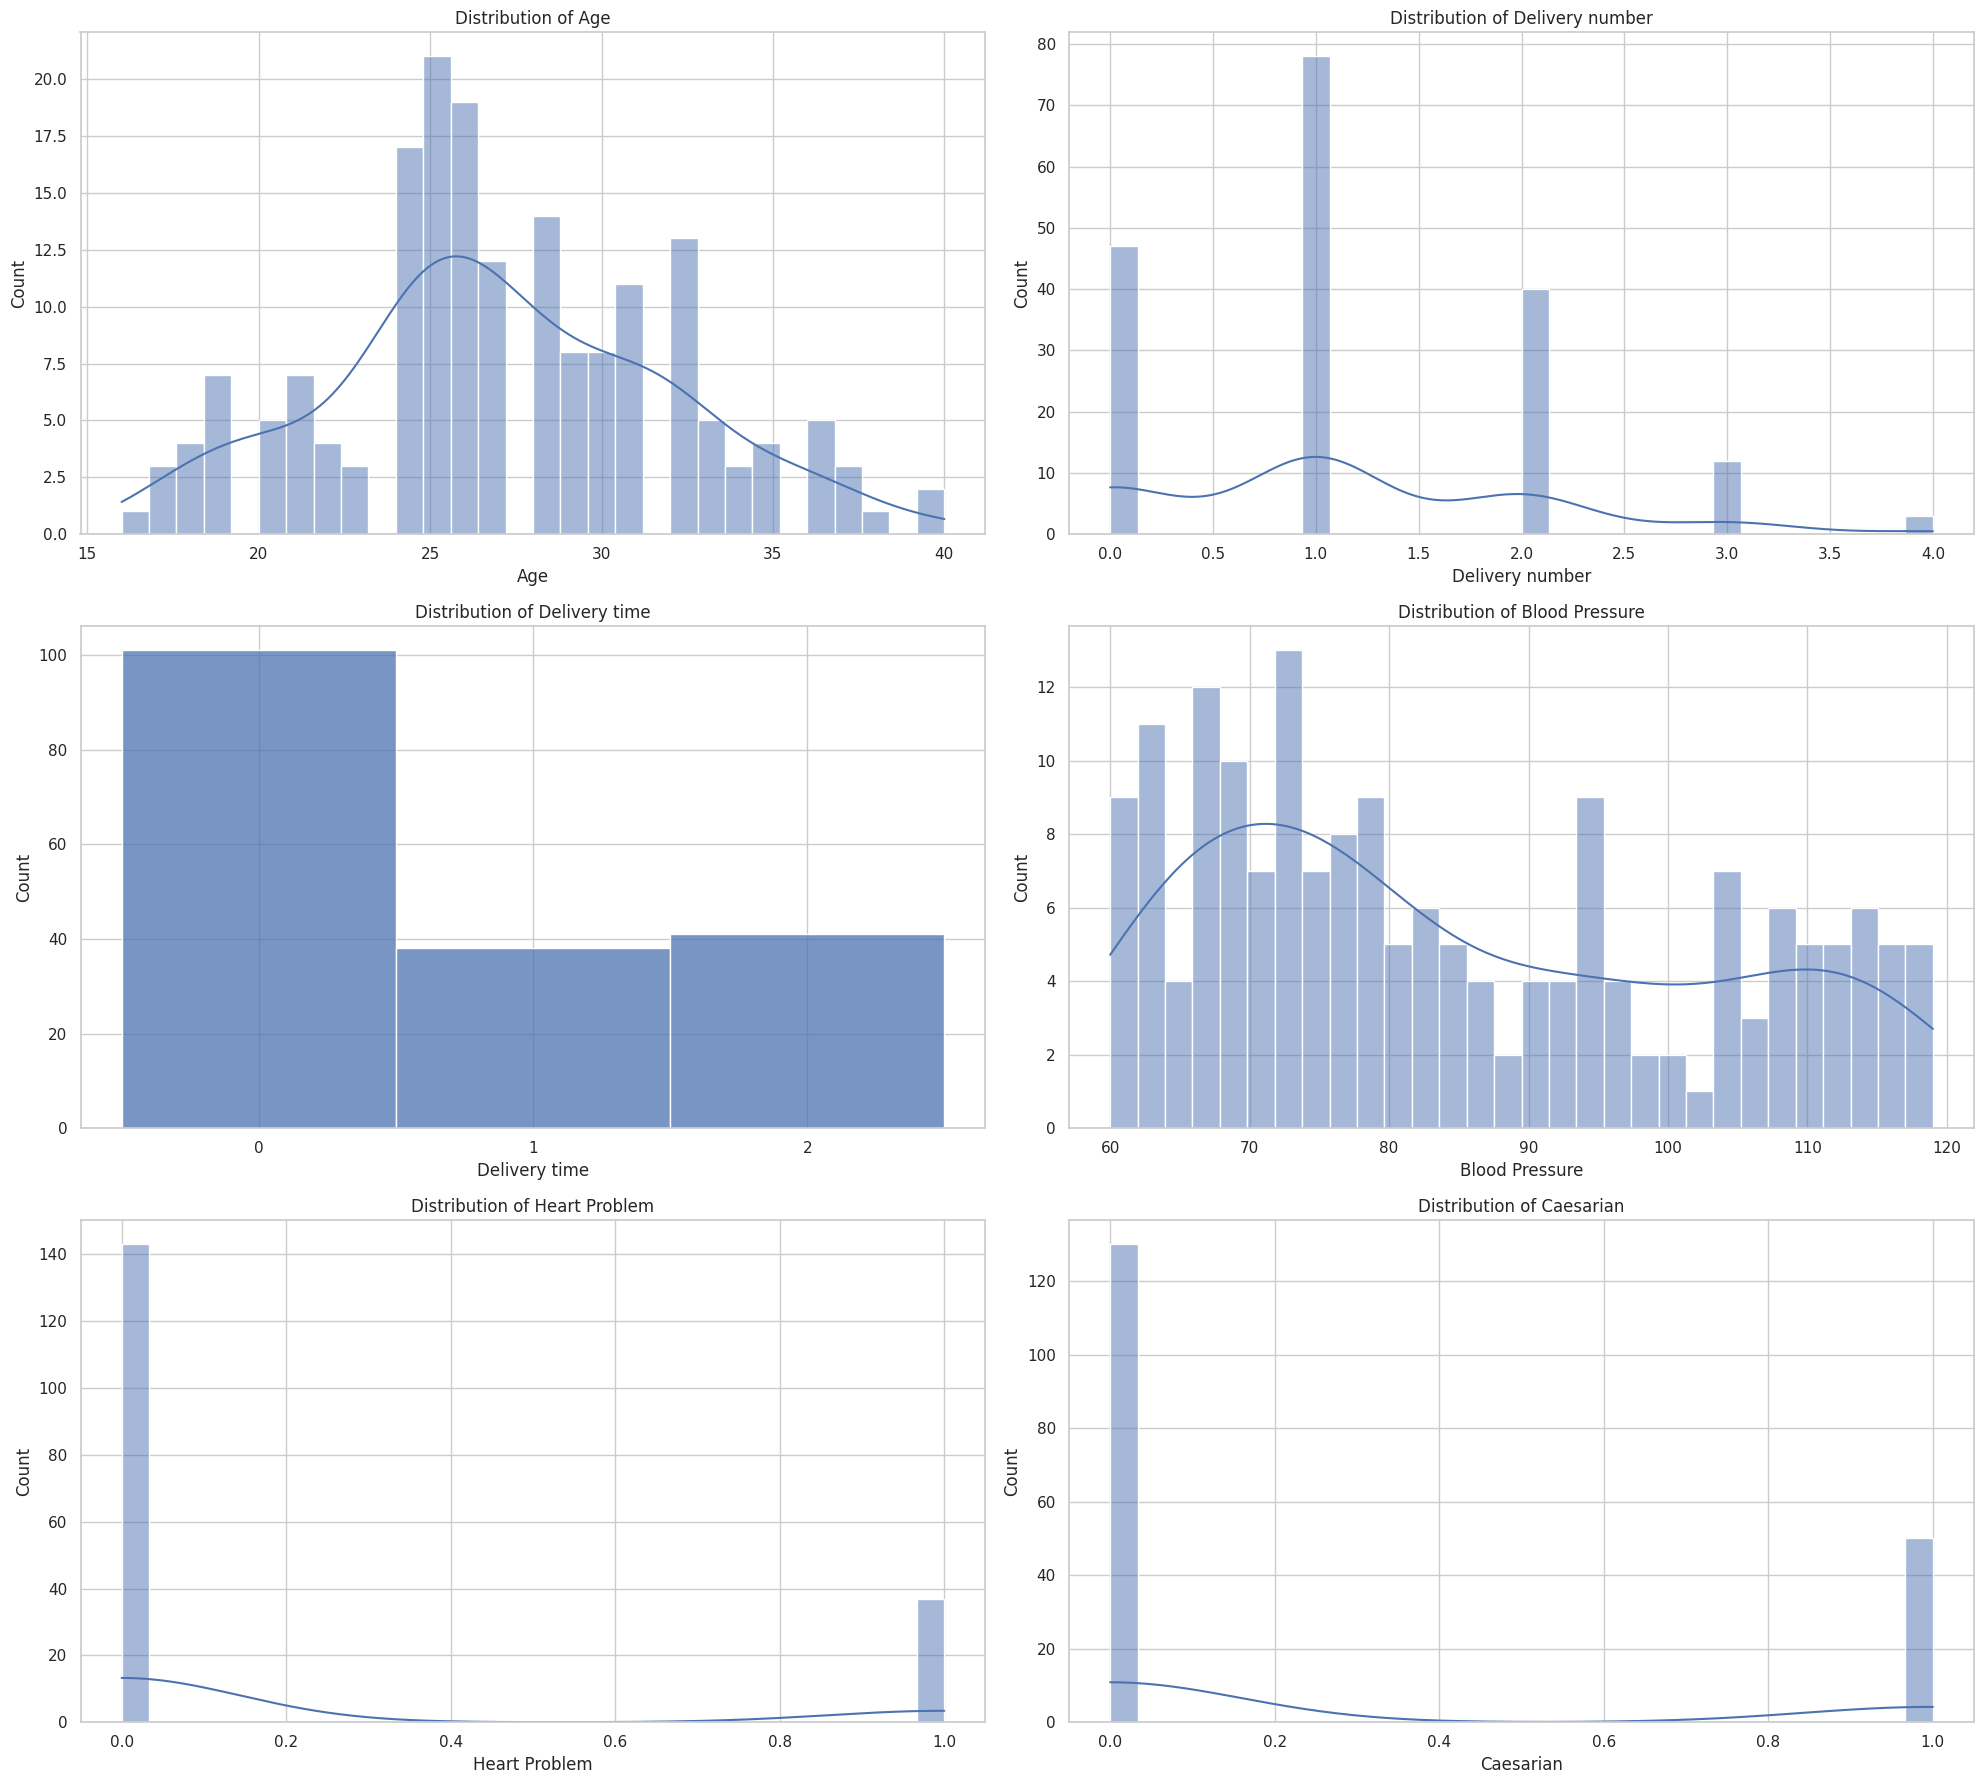

Pair plot for numeric features:


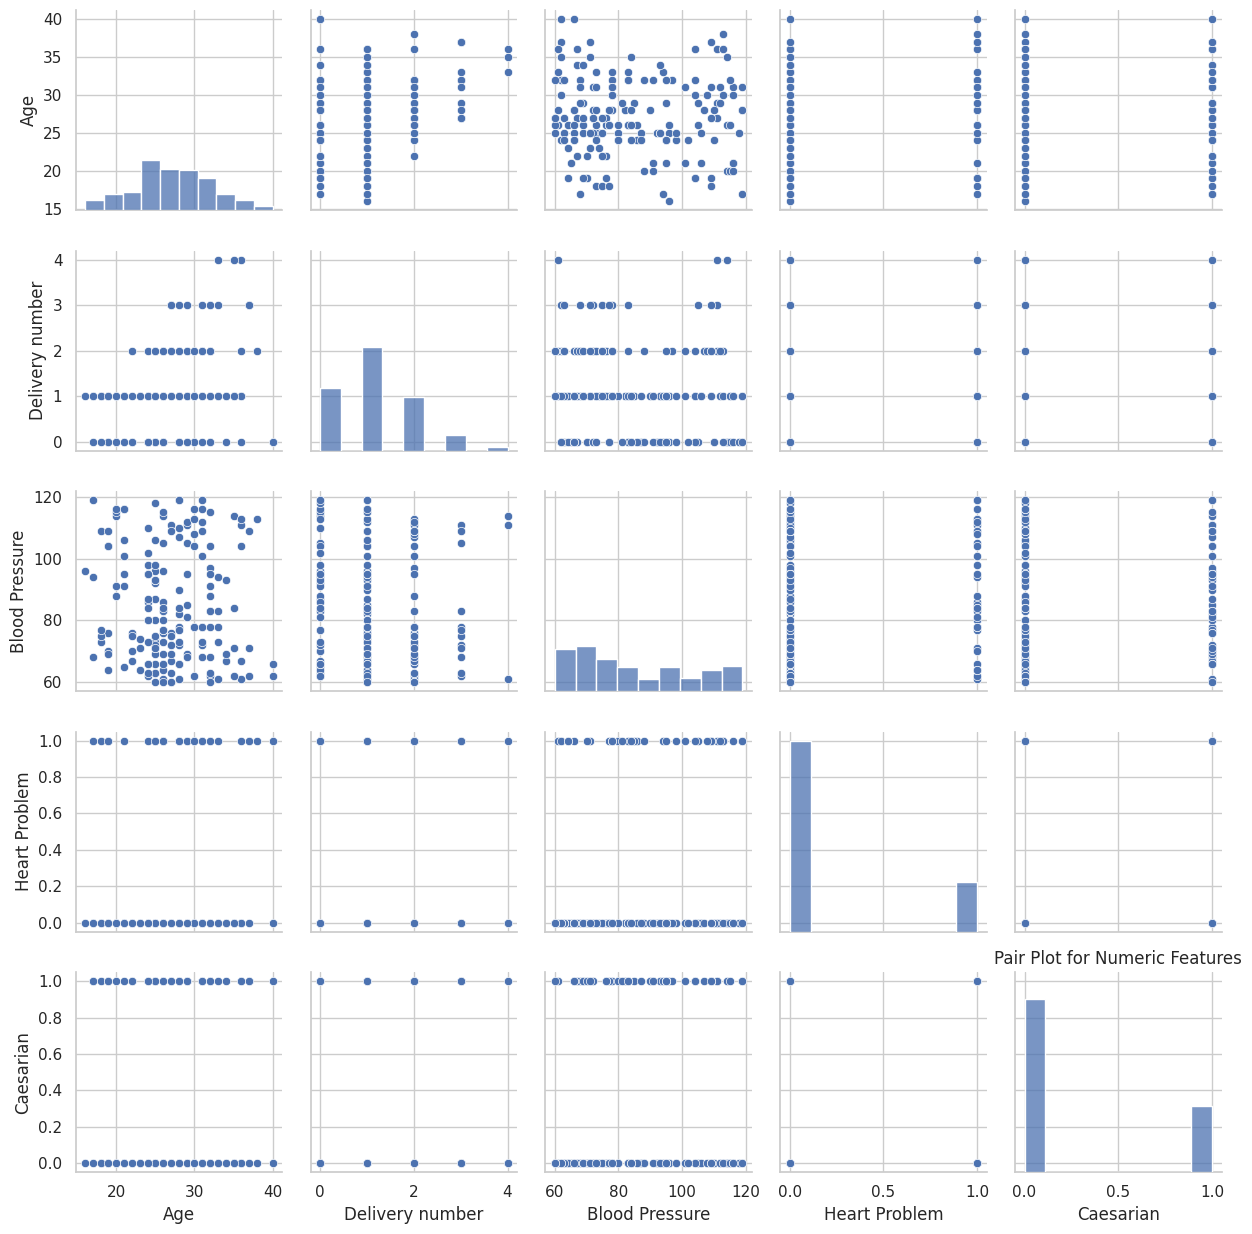

Correlation matrix:
                      Age  Delivery number  Blood Pressure  Heart Problem  \
Age              1.000000         0.370700       -0.059796       0.119252   
Delivery number  0.370700         1.000000       -0.126888       0.009612   
Blood Pressure  -0.059796        -0.126888        1.000000       0.134792   
Heart Problem    0.119252         0.009612        0.134792       1.000000   
Caesarian        0.054543         0.036746        0.151727       0.114248   

                 Caesarian  
Age               0.054543  
Delivery number   0.036746  
Blood Pressure    0.151727  
Heart Problem     0.114248  
Caesarian         1.000000  
Plotting correlation heatmap:


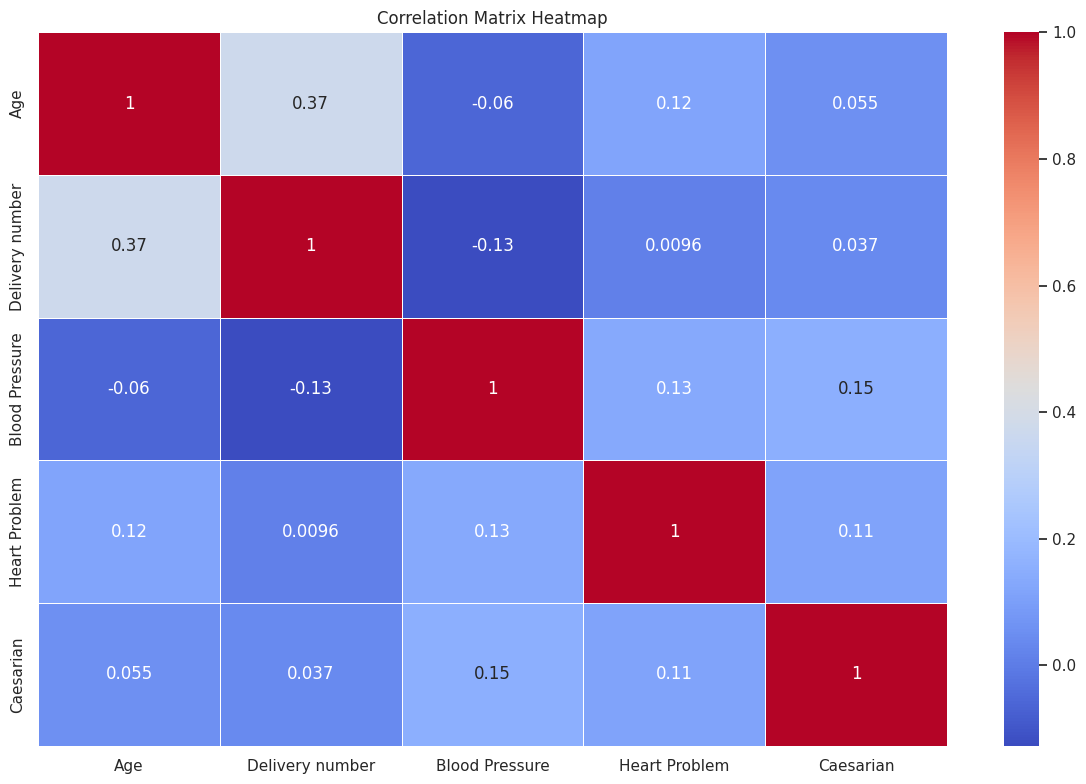

Plotting scatter matrix for numeric features:


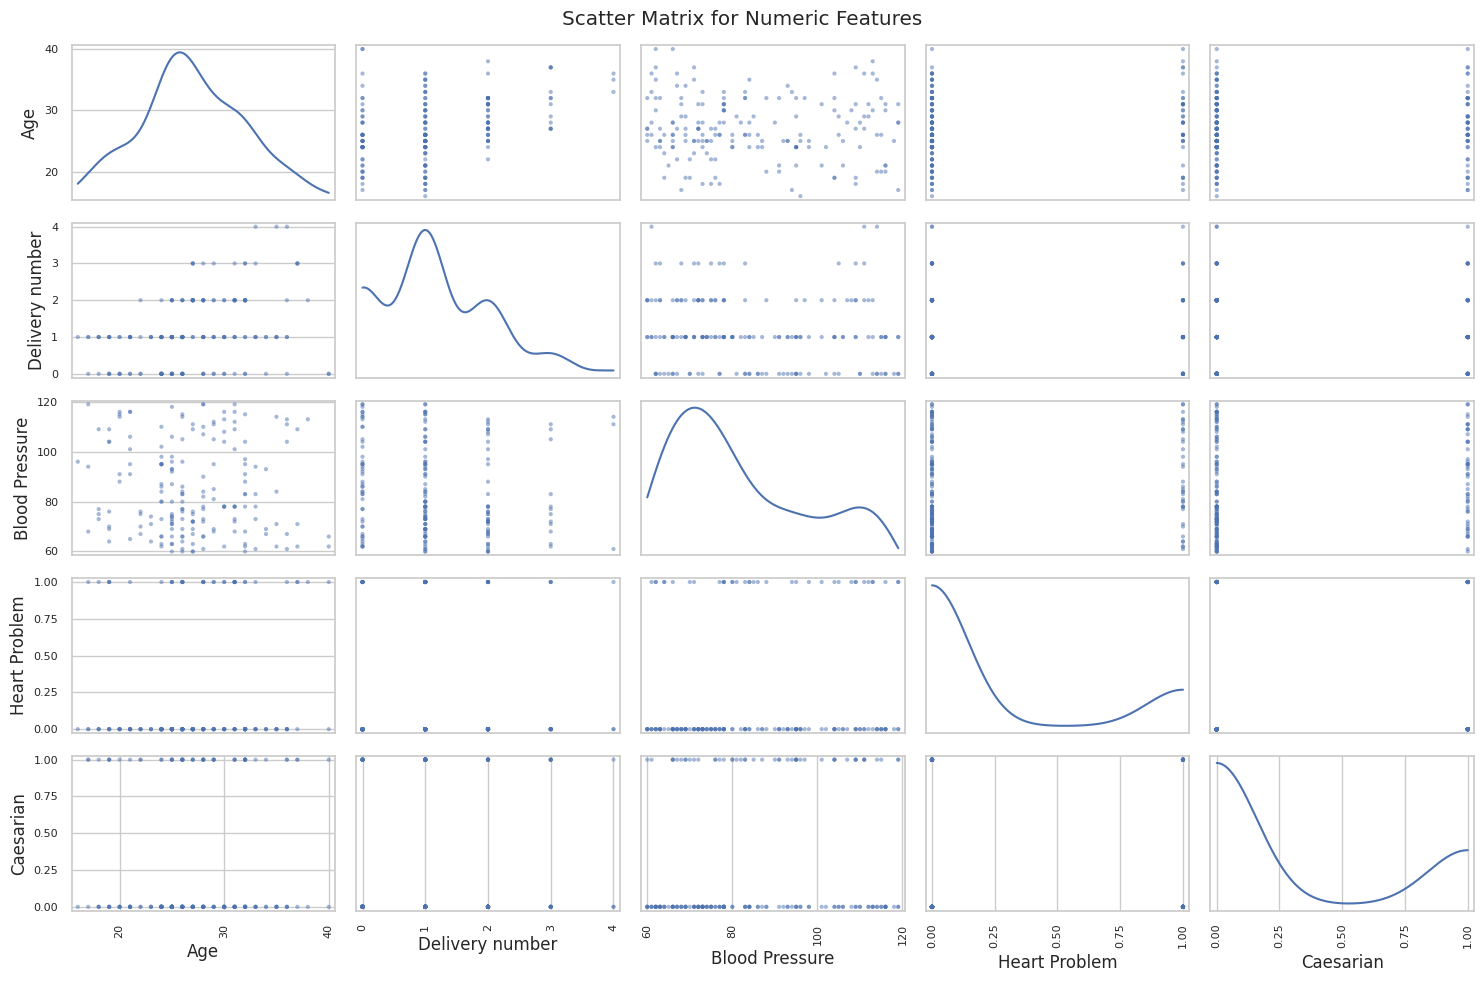

Plotting boxplots for numeric features:


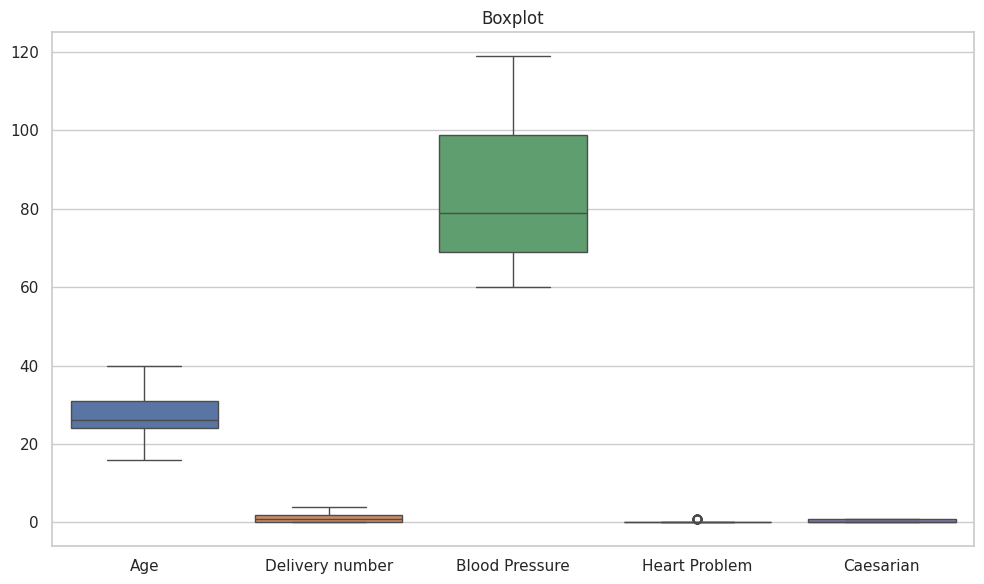

Plotting count plots for categorical features:


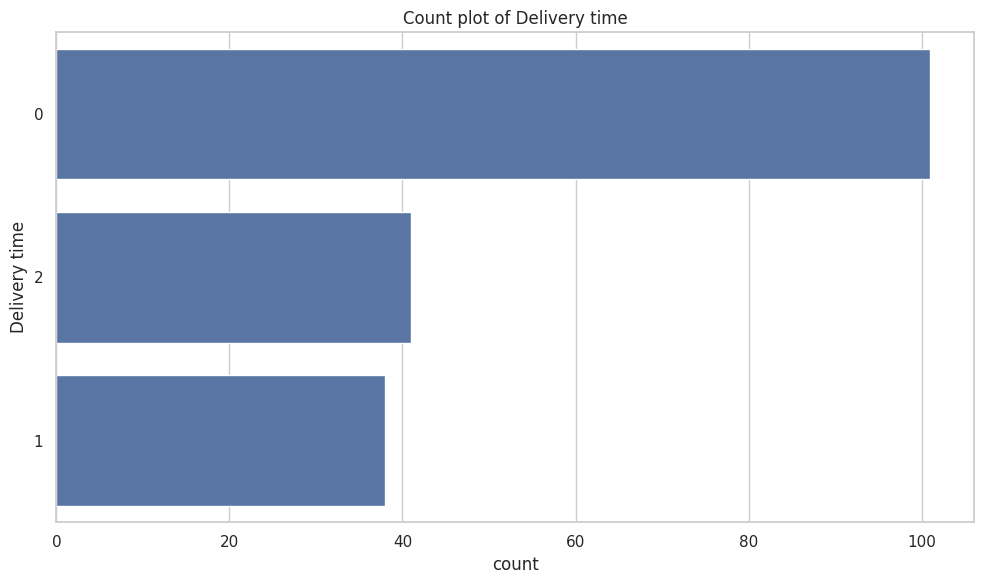

Detecting outliers using Z-score method:
{'Age': array([], dtype=int64), 'Delivery number': array([ 29,  67, 109]), 'Blood Pressure': array([], dtype=int64), 'Heart Problem': array([], dtype=int64), 'Caesarian': array([], dtype=int64)}

Summary of Exploratory Data Analysis:
Dataset contains 180 rows and 6 columns.
Numeric columns: ['Age', 'Delivery number', 'Blood Pressure', 'Heart Problem', 'Caesarian']
Categorical columns: ['Delivery time']


In [60]:
exploratory_data_analysis(data_frame)